In [1]:
"Timetable parsing"

from tramnetwork import *

lookup_day = "20250128"

network = TramNetwork()
network.load_day(lookup_day)

loaded routes.txt
loaded transfers.txt
loaded stops.txt
loaded trips.txt
loaded stop_times.txt
loaded calendar.txt
loaded calendar_dates.txt
Found 203 Tram Stops (20250128).          


In [2]:
"test timetable"

search_query = "Letzi"

time = gt_parse_time("12:00:00", lookup_day)
stop = network.search_stops(search_query)[0]
departures = stop.get_departures_after(time)
first_departure = departures[0]

print(f"Next Departure from {stop.name} is at {first_departure.departure_time} with {first_departure.tram_name}:")
print(first_departure)

Next Departure from Zürich, Letzistrasse is at 2025-01-28 12:00:18 with T9:
[2025-01-28 12:00:06] Zürich, Letzistrasse           (T9) [2025-01-28 12:00:18]
[2025-01-28 12:00:54] Zürich, Kinkelstrasse          (T9) [2025-01-28 12:01:06]
[2025-01-28 12:02:00] Zürich, Seilbahn Rigiblick     (T9) [2025-01-28 12:02:18]
[2025-01-28 12:03:12] Zürich, Winkelriedstrasse      (T9) [2025-01-28 12:03:24]
[2025-01-28 12:04:18] Zürich, Haldenbach             (T9) [2025-01-28 12:04:30]
[2025-01-28 12:05:42] Zürich, ETH/Universitätsspital (T9) [2025-01-28 12:06:00]
[2025-01-28 12:07:18] Zürich, Kantonsschule          (T9) [2025-01-28 12:07:30]
[2025-01-28 12:08:48] Zürich, Kunsthaus              (T9) [2025-01-28 12:09:06]
[2025-01-28 12:11:00] Zürich, Bellevue               (T9) [2025-01-28 12:11:30]
[2025-01-28 12:13:06] Zürich, Bürkliplatz            (T9) [2025-01-28 12:13:24]
[2025-01-28 12:14:36] Zürich, Kantonalbank           (T9) [2025-01-28 12:14:54]
[2025-01-28 12:15:48] Zürich, Paradeplatz   

In [3]:
"pathfinding using djikstra"

import bisect

MAX_TRANSITION_SECONDS = 30 * 60
MIN_CHANGE_BUFFER_SECONDS = 30

class NoConnectionsLeftException(Exception):
    pass

def calc_dijkstra_path_to(start_time: datetime, start: TramStop, destination_criterium,
                          start_tram: TramName=None, weight_func=None) -> TramPath:
    visited_stops = set()
    start_connection = TramPath([start], [start_time], [None], [None])
    visit_stack = [(0, start_time, start_connection, start)]

    while len(visit_stack) > 0:
        _, curr_time, prev_stops, stop = visit_stack.pop(0)
        if stop in visited_stops:
            continue

        visited_stops.add(stop)
        if destination_criterium(stop):
            return prev_stops

        connections = stop.get_departures_after(curr_time)
        for connection in connections:
            wait_seconds = (connection.arrival_time - curr_time).total_seconds()
            
            if len(prev_stops) >= 2:
                last_tram_name = prev_stops.transportation_names[-2]
            else:
                last_tram_name = start_tram

            if last_tram_name is not None and connection.tram_name != last_tram_name:
                # it's a change of tram!
                if wait_seconds < MIN_CHANGE_BUFFER_SECONDS:
                    continue

            if wait_seconds >= MAX_TRANSITION_SECONDS:
                break

            new_stop = connection.stops[1]
            new_time = connection.arrival_times[1]
            if new_stop in visited_stops:
                continue

            prev_stops_copy = prev_stops.slice(0)
            prev_stops_copy.stop_departure_times[-1] = connection.departure_time
            prev_stops_copy.transportation_names[-1] = connection.tram_name

            prev_stops_copy.add_stop(new_stop, new_time, None, None)
            
            weight = new_time.timestamp()
            if weight_func is not None:
                weight += weight_func(new_stop)

            bisect.insort(visit_stack, (weight, new_time, prev_stops_copy, new_stop))
            
    raise NoConnectionsLeftException("Couldn't find connection in time")

def calc_dijkstra_path_between(start_time: datetime, start: TramStop, destination: TramStop,
                               start_tram: TramName=None, weight_func=None) -> TramPath:
    destination_criterium = lambda stop: stop == destination
    return calc_dijkstra_path_to(start_time, start, destination_criterium, start_tram=start_tram, weight_func=weight_func)

stop1 = network.search_stops("Albis")[0]
stop2 = network.search_stops("Flug")[0]
start_time = gt_parse_time("12:00:00", lookup_day)

connection = calc_dijkstra_path_between(start_time, stop1, stop2)
connection.print_summary()

Start: Zürich, Albisgütli
Destination: Zürich Flughafen, Bahnhof
Total Time: 0:52:18
Start Time: 2025-01-28 12:03:00
Total Stops: 35


In [4]:
"nearest neighbour search"

def calc_nearest_neighbor_search(start_stop: TramStop, start_time: datetime, weight_func=None) -> TramPath:
    unvisited_stops = set(network.stops)
    unvisited_stops.remove(start_stop)
    destination_criterium = lambda stop: stop in unvisited_stops
    visit_count = 0

    curr_stop = start_stop
    curr_time = start_time
    path = TramPath()
    curr_tram = None
    while len(unvisited_stops) > 0:
        new_path = calc_dijkstra_path_to(curr_time, curr_stop, destination_criterium, start_tram=curr_tram, weight_func=weight_func)
        curr_time = new_path.arrival_times[-1]

        visit_count += 1
        path.add_path(new_path)
        curr_stop = path.stops[-1]
        curr_tram = path.transportation_names[-2]
        unvisited_stops.remove(curr_stop)

    return path

letzi = network.search_stops("Letzi")[0]
start_time = gt_parse_time("10:00:00", lookup_day)

nearest_neighbour_path = calc_nearest_neighbor_search(letzi, start_time)
nearest_neighbour_path.print_summary()

Start: Zürich, Letzistrasse
Destination: Zürich, Wollishoferplatz
Total Time: 10:43:12
Start Time: 2025-01-28 10:00:18
Total Stops: 374


In [5]:
"test loading old path"

genetic_path = TramPath.load("genetic.2025-01-28--9-10-36.txt", network)
genetic_path.print_summary()

Start: Zürich, Letzistrasse
Destination: Schlieren, Geissweid
Total Time: 9:10:36
Start Time: 2025-01-28 09:45:24
Total Stops: 314


In [6]:
"calc stop-heuristics for later optimization"

import random

heuristic_map: dict[TramStop, dict[str, float]] = {}
neighbour_map: dict[TramStop, set[TramStop]] = {}

min_connections = min(len(s.connections) for s in network.stops)
max_connections = max(len(s.connections) for s in network.stops)

min_lat = min(s.coords[0] for s in network.stops)
min_lon = min(s.coords[1] for s in network.stops)
max_lat = max(s.coords[0] for s in network.stops)
max_lon = max(s.coords[1] for s in network.stops)

for stop in network.stops:
    heuristics = {}

    neighbour_map[stop] = set(c.stops[1] for c in stop.connections) - set([stop])
    heuristics["popularity"] = len(neighbour_map[stop])
    heuristics["connectivity"] = (len(stop.connections) - min_connections) / (max_connections - min_connections)
    heuristics["spider-leg"] = 1 if heuristics["popularity"] == 1 else 0
    heuristics["distance_sum"] = sum(
        1 / (haversine_distance(stop.coords, other.coords) * 10) ** 2
        for other in network.stops if stop != other 
    )
    heuristics["lat"] = (stop.coords[0] - min_lat) / (max_lat - min_lat)
    heuristics["lon"] = (stop.coords[1] - min_lon) / (max_lon - min_lon)
    heuristics["random"] = random.random()

    heuristic_map[stop] = heuristics

for i in range(len(network.stops)):
    for stop in network.stops:
        neighbours = neighbour_map[stop]
        if len(neighbours) != 2:
            continue
        if any(heuristic_map[n]["spider-leg"] for n in neighbours):
            heuristic_map[stop]["spider-leg"] = 1

heuristic_names = list(list(heuristic_map.values())[0].keys())

In [ ]:
"time dependant ant colony optimization"

import json

# precomputed_distance_matrix: dict[TramStop, dict[TramStop, float]] = {}
# with open("graph-exports/graph2.txt", "r") as file:
#     distances = json.load(file)["distance_matrix"]
#     precomputed_distance_matrix = {
#         stop1: {
#             stop2: distances[i][j]
#             for j, stop2 in enumerate(network.stops)
#         }
#         for i, stop1 in enumerate(network.stops)
#     }

pheromone_map: dict[TramStop, dict[TramStop, dict[datetime, float]]] = None

def reset_pheromone_map():
    global pheromone_map
    pheromone_map = {
        stop1: {stop2: {} for stop2 in network.stops}
        for stop1 in network.stops
    }

best_ant_path: TramPath = None

def ant_colony_opt(start_time: datetime, start_stop: TramStop, num_ants=50, generations=100,
                   reset_pheromones=True, pheromone_strength=0.01, pheromone_decay_factor=0.9):
    global best_ant_path
    if pheromone_map is None or reset_pheromones:
        reset_pheromone_map()

    def simulate_ant(ant_index: int) -> TramPath:
        curr_path = TramPath()
        curr_path.add_stop(start_stop, start_time)
        curr_tram = None
        decisions = []

        print(f"> simulating ant#{(ant_index + 1):03}", end="\r")
        
        remaining_stops = set(network.stops) - set(curr_path.stops)
        while len(remaining_stops) > 0:
            curr_stop = curr_path.stops[-1]
            curr_time = curr_path.arrival_times[-1]

            def get_weight(stop: TramStop) -> float:
                time_map = pheromone_map[curr_stop][stop]
                if curr_time not in time_map:
                    time_map[curr_time] = 0.
                return -time_map[curr_time]

            try:
                new_path = calc_dijkstra_path_to(
                    curr_path.arrival_times[-1],
                    curr_stop,
                    lambda stop: stop in remaining_stops,
                    start_tram=curr_tram,
                    weight_func=get_weight
                )
            except NoConnectionsLeftException:
                return None

            new_stop = new_path.stops[-1]
            decisions.append((curr_stop, new_stop, curr_time))
            curr_path.add_path(new_path)
            curr_tram = curr_path.transportation_names[-2]
            remaining_stops.remove(new_stop)

        return curr_path, decisions

    print(f"Starting Ant Colony Optimization. {num_ants=} {generations=}")
    for gen_index in range(generations):

        # simulate all the ants
        ant_paths: list[TramPath] = []
        ant_decision_list: list[list[tuple[TramStop, TramStop, datetime]]] = []

        for ant_index in range(num_ants):
            ant_result = simulate_ant(ant_index)
            if ant_result is not None:
                ant_path, ant_decisions = ant_result
                ant_paths.append(ant_path)
                ant_decision_list.append(ant_decisions)

        # drop pheromones based on ant paths
        print("> dropping pheromones from ants", end="\r")
        for ant_path, ant_decisions in zip(ant_paths, ant_decision_list):
            path_seconds = ant_path.time_delta().total_seconds()
            pheromone_drop = path_seconds / len(network.stops) * pheromone_strength
            for start_stop, end_stop, start_time in ant_decisions:
                pheromone_map[start_stop][end_stop][start_time] += pheromone_drop

            if best_ant_path is None or path_seconds < best_ant_path.time_delta().total_seconds():
                best_ant_path = ant_path

        # decay pheromones a bit 
        print("> decaying all pheromones a bit", end="\r")
        for stop1 in network.stops:
            for stop2 in network.stops:
                for time in pheromone_map[stop1][stop2].keys():
                    pheromone_map[stop1][stop2][time] *= pheromone_decay_factor

        print(f"Gen{gen_index + 1:03}: best={best_ant_path.time_delta()} survivors={len(ant_paths)}")

    return best_ant_path
                
ant_colony_opt(
    gt_parse_time("9:45:00", lookup_day),
    network.search_stops("Letzi")[0],
    num_ants=100,
    generations=100,
    reset_pheromones=True,
    pheromone_strength=0.01,
    pheromone_decay_factor=0.9
)

Starting Ant Colony Optimization. num_ants=100 generations=100


In [7]:
"optimize heuristic weights to find optimal nearest neighbour search path"

import random, numpy
from functools import cached_property

start_stop = network.search_stops("Letzi")[0]
start_time = gt_parse_time("9:45:00", lookup_day)

MIN_TIME_DELTA = timedelta(hours=9)

class StopWeighting:

    def __init__(self, weights=None):
        if weights is None:
            self.weights = tuple(0 for _ in range(len(heuristic_names)))
        else:
            self.weights = tuple(weights)
            assert len(self.weights) == len(heuristic_names)

    def mutate(self, mutation_chance: float, mutation_rate: float) -> "StopWeighting":
        new_weights = list(self.weights)
        for i in range(len(self.weights)):
            if random.random() < mutation_chance:
                new_weights[i] = self.weights[i] + numpy.random.normal(0, 1) * mutation_rate
        return StopWeighting(new_weights)
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.weights!r})"
    
    def __str__(self):
        return repr(self)

    def copy(self):
        return StopWeighting(self.weights)
    
    @classmethod
    def zero(cls):
        return StopWeighting()
    
    @classmethod
    def random(cls):
        return StopWeighting([
            numpy.random.normal(0, 1)
            for _ in range(len(heuristic_names))
        ])

    def make_weight_func(self):
        def get_weight(stop):
            return sum(
                (self.weights[i] * 100) * heuristic_map[stop][h]
                for i, h in enumerate(heuristic_names)
            )
        return get_weight
    
    @cached_property
    def weighted_path(self) -> TramPath:
        try:
            return calc_nearest_neighbor_search(
                start_stop, start_time, self.make_weight_func()
            )
        except NoConnectionsLeftException:
            return None
    
    def calc_score(self) -> float:
        if self.weighted_path is not None:
            delta = self.weighted_path.time_delta() - MIN_TIME_DELTA
            return (10000 / delta.total_seconds()) ** 6
        else:
            return 0
    
    def __hash__(self):
        return hash(self.weights)

population = [
    StopWeighting.random()
    for i in range(30)
]

best_genetic_path = None
best_genetic_delta = None

print(f"Starting Genetic Algorithm population_size={len(population)}")
for gen_index in range(100):
    # evaluation
    evaluations = {
        weighting: weighting.calc_score()
        for weighting in population
    }

    survivor_count = sum(e > 0 for e in evaluations.values())

    # selection
    population.sort(key=lambda w: evaluations[w], reverse=True)
    parents = population[:10]
    parent_evaluations = [evaluations[p] for p in parents]
    best = population[0]

    # update global best
    if best_genetic_delta is None or best.weighted_path.time_delta() < best_genetic_delta:
        best_genetic_delta = best.weighted_path.time_delta()
        best_genetic_path = best.weighted_path

    # reproduction and mutation
    for i in range(5, len(population)):
        random_parent = random_choice_distribution(parents, parent_evaluations)
        population[i] = random_parent.mutate(0.25, 1 / (gen_index + 1) + 0.15)
        
    print(f"Gen{gen_index + 1}: s={survivor_count} {best_genetic_delta}, {best}")

Starting Genetic Algorithm population_size=30
Gen1: s=30 9:54:06, StopWeighting((-0.5556024883769097, 0.12263704155947235, -1.864936180137746, 1.1543616048878211, 1.6212080705977705, 0.3456226959583181, -0.03993635693865059))


KeyboardInterrupt: 

In [200]:
"save genetic opt result"

name = "genetic-opt"
best_genetic_path.save(name)
best_genetic_path.save_image(name)

'genetic-opt.2025-01-28--9-32-30.png'

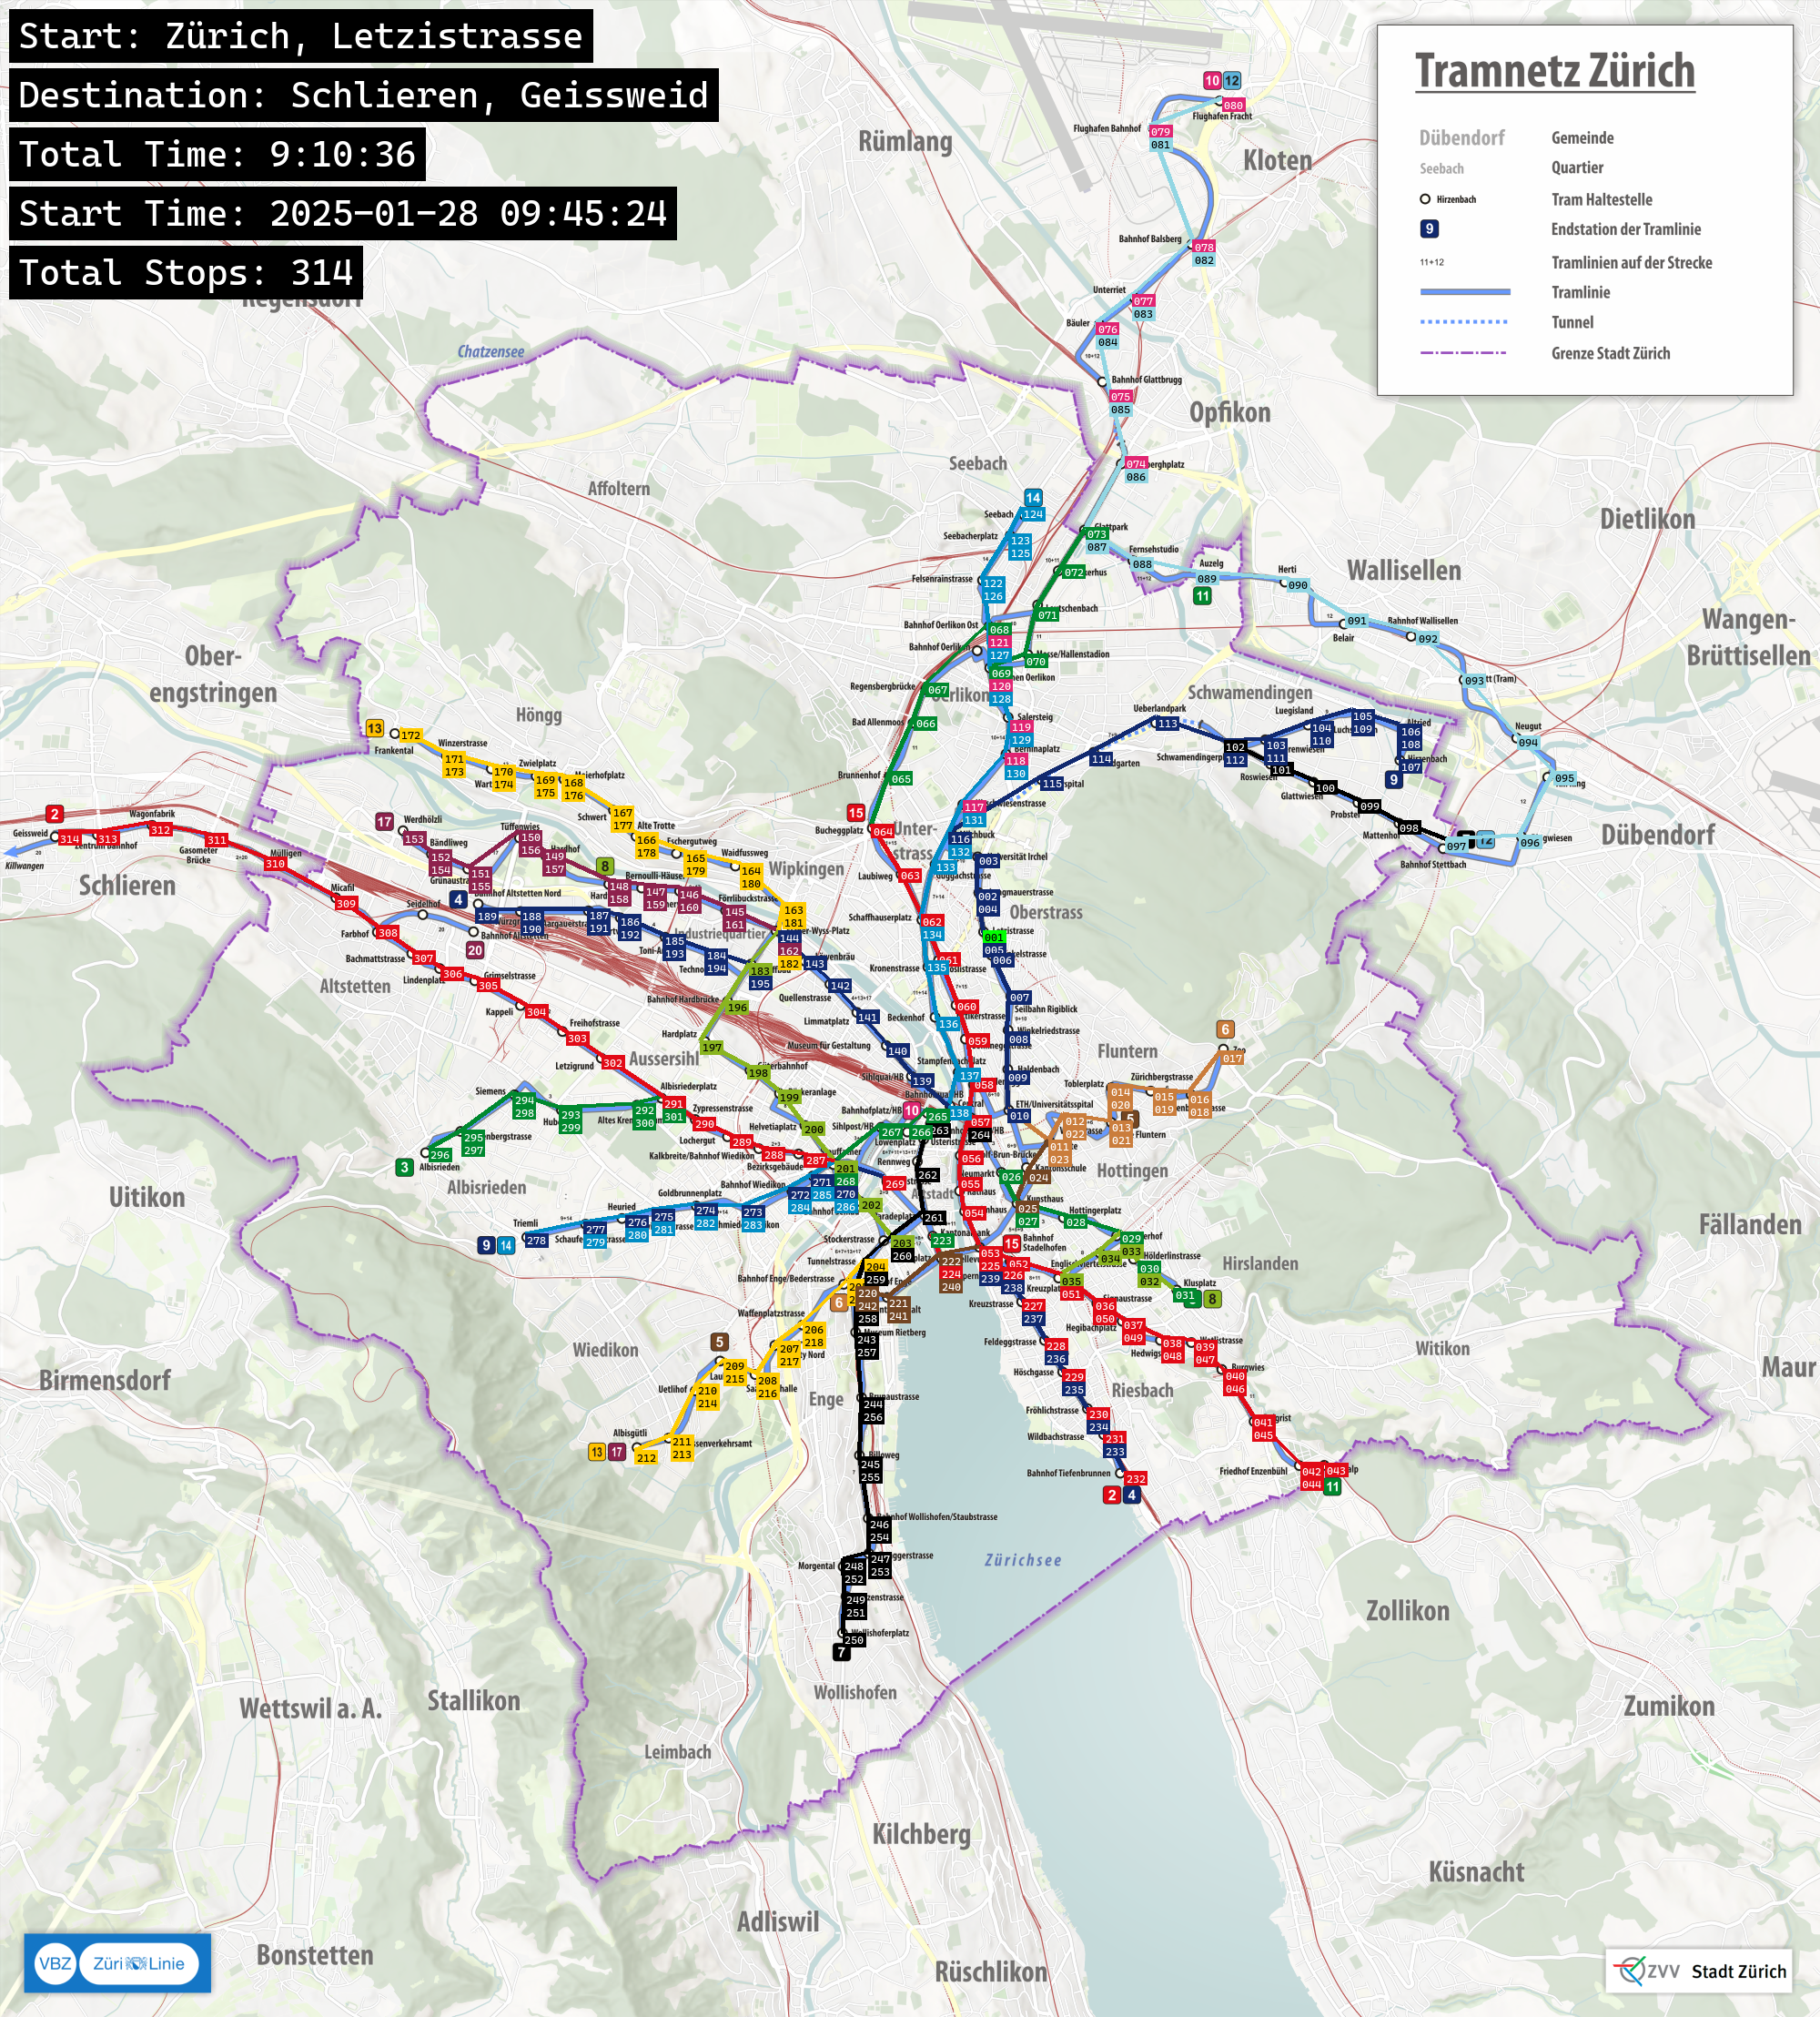

In [218]:
TramPath.load("genetic.2025-01-28--9-10-36.txt", network).generate_image()